In [14]:
%matplotlib inline
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt

In [15]:
def costfun(x,dt,p,u0,uv,uw):
    f = len(x)/2
    n = x[:f];
    r = x[f:];
    u = u0 + uv*r;
    d = np.append(np.diff(n), n[0]-n[-1]);
    return dt*np.sum(p*n*u)+uw*np.sum(p*d*(d>0)) ;

In [16]:
cl1 = (0.22,0.42,0.69)
cl2 = (0.85,0.49,0.19)

In [31]:
T = 24 #number of hours to model
dt = 1
t = np.arange(0,T,dt)

p0 = 1  # baseline cost ($/watt)

u0 = 1 # power used to idle node
uv = 3 # power used on running max cpus
uw = 0.1 # power wasted in powering on a node (hour/node powered on)

fs = [2, 4, 6, 8]
pfs = [0.1, 0.05, 0.01] # size of daily price fluctuation ($/hour)
nms = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [36]:
stox = []
stop = []
for f in fs:
    S = f*T
    for pf in pfs:
        p = p0 + pf*np.sin(2*np.pi*t/24) # variable price function
        v = []
        stop.append(nms)
        for nm in nms:
            if(nm>=f):
                #Constrain the total usage to be equal to whatever is need
                cons = ({'type': 'eq', 'fun': lambda x:  S - dt*sum(x[:len(x)/2]*x[len(x)/2:])})

                bnds = tuple([(0,nm),]*len(p)+[(0,1),]*len(p))

                x0 = np.hstack([S/T*np.ones(np.size(p)),0.5*np.ones(np.size(p))]) #initial guess for solution
                ex = (dt,p,u0,uv,uw)
                opt = {'disp': False, 'iprint': 1, 'eps': 1.4901161193847656e-08, 'maxiter': 100000, 'ftol': 1e-08}
                res = minimize(costfun, x0, args=ex, method='SLSQP',bounds=bnds,constraints=cons,options=opt)
                C = costfun(res.x,dt,p,u0,uv,uw)
                v.append(C)
            else:
                v.append(np.nan)
        stox.append(v)


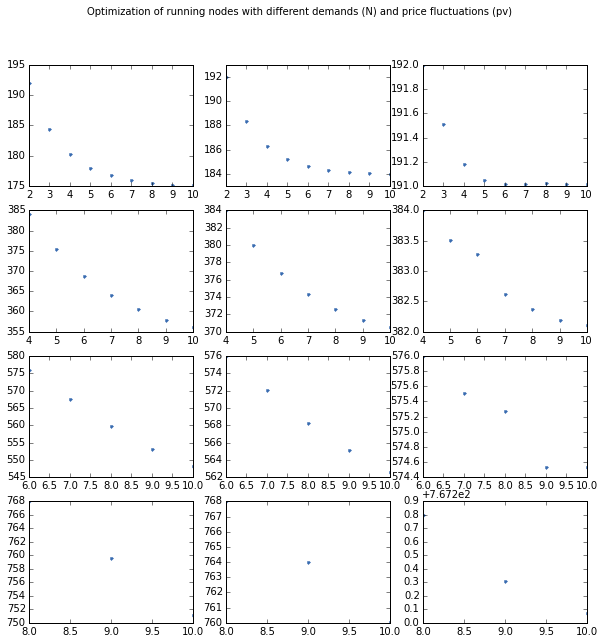

In [39]:
ind = 1
nN = len(fs);
nP = len(pfs)   
fig = plt.figure(figsize=(10,10))
for f in fs:
    for pv in pfs:
        N = f*T*nm # Total amount of node runtime needed
        p = stop[ind-1] # variable price function
        n = stox[ind-1]
        
        ax1 = plt.subplot(nN,nP,ind)

        
        ax1.plot(p, n, '.',color=cl1)
#         ax1.set_ylim([0.9*min(n), 1.1*max(n)])
        
        ind = ind+1
plt.suptitle("Optimization of running nodes with different demands (N) and price fluctuations (pv)")